In [1]:
# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive

In [3]:
# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

# Automate dataset handling (download and extraction)
dataset_zip_path = '/content/drive/MyDrive/CSC667/DATASET.zip'

Mounting Google Drive...
Mounted at /content/drive


In [5]:
# Extract dataset
import zipfile

print("Extracting the dataset...")
extracted_path = 'dataset'
with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)
print("Dataset extracted!")

Extracting the dataset...
Dataset extracted!


In [9]:
# Step 1: Locate the correct PlantVillage folder dynamically
def find_correct_folder(base_path, target_folder_name="PlantVillage"):
    for root, dirs, files in os.walk(base_path):
        if target_folder_name in dirs:
            return os.path.join(root, target_folder_name)
    return None

# Dynamically find the correct PlantVillage folder
dataset_path = find_correct_folder('/content/dataset')
if dataset_path:
    print(f"Found dataset folder at: {dataset_path}")
else:
    raise Exception("Dataset folder not found! Please check the structure.")

Found dataset folder at: /content/dataset/PlantVillage


In [10]:
# Step 2: Load and preprocess the dataset
def load_and_preprocess_dataset(dataset_path):
    data = []
    labels = []
    for class_folder in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_folder)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    image = cv2.imread(img_path)
                    if image is not None:
                        # Resize image to a standard size
                        image = cv2.resize(image, (128, 128))

                        # Feature extraction: RGB color histogram
                        hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten()

                        # Grayscale conversion for texture and shape features
                        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

                        # Texture: GLCM features (using CLAHE for simplicity)
                        glcm = cv2.createCLAHE().apply(gray).flatten()
                        glcm_features = [np.mean(glcm), np.std(glcm)]

                        # Shape: Edge detection (Canny)
                        edges = cv2.Canny(gray, 100, 200)
                        edge_features = [np.sum(edges), np.mean(edges)]

                        # Combine all features
                        features = np.concatenate((hist, glcm_features, edge_features))
                        data.append(features)
                        labels.append(class_folder)
                except Exception as e:
                    print(f"Skipped {img_path} due to error: {e}")
    return np.array(data), np.array(labels)

# Load the dataset
X, y = load_and_preprocess_dataset(dataset_path)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [11]:
# Step 3: Define models and evaluation process as per intermediate presentation review feedback

kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = {
    "SVM (RBF Kernel)": SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "k-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

In [12]:
# Evaluate models using k-fold cross-validation as per intermediate presentation review feedback

results = {}
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X, y_encoded, cv=kf, scoring='accuracy')
    results[model_name] = {
        "Mean Accuracy": np.mean(cv_scores),
        "Std Dev": np.std(cv_scores)
    }

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

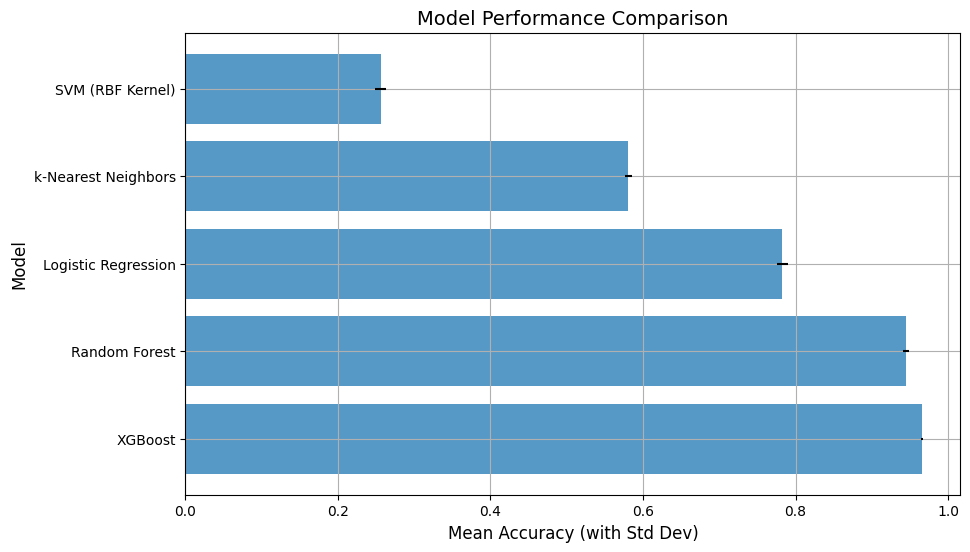

In [13]:
# Step 4: Visualize results
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by="Mean Accuracy", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(results_df.index, results_df['Mean Accuracy'], xerr=results_df['Std Dev'], alpha=0.75)
plt.xlabel('Mean Accuracy (with Std Dev)', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.title('Model Performance Comparison', fontsize=14)
plt.grid(True)
plt.show()

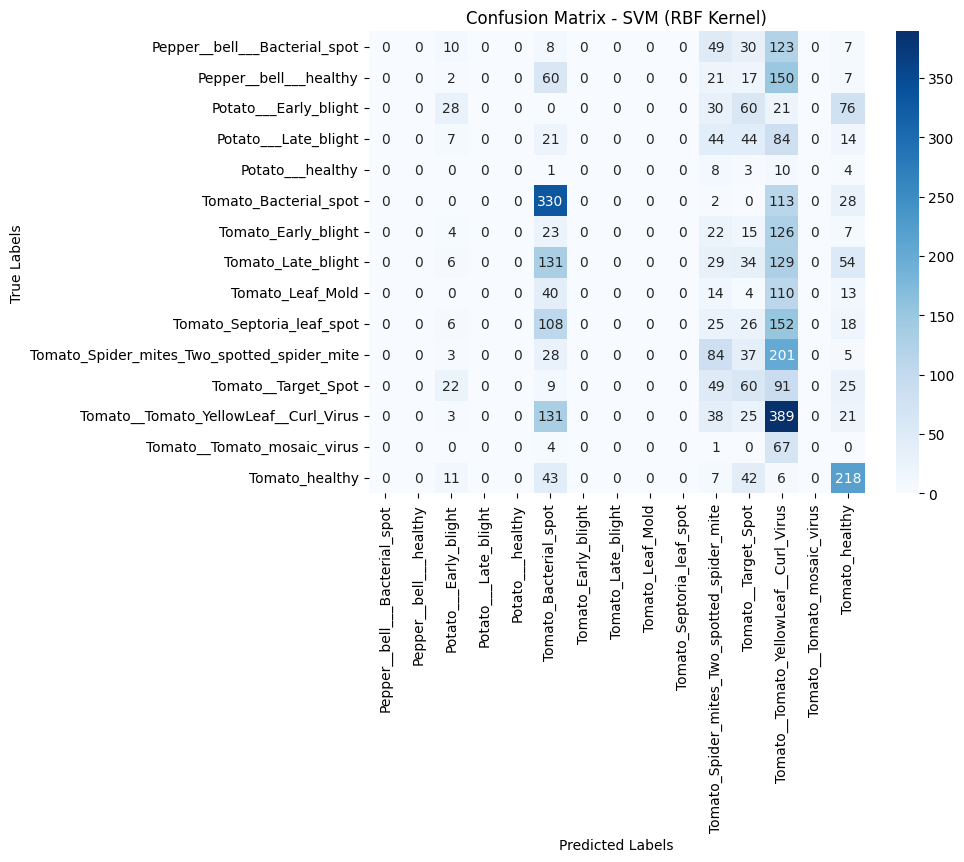

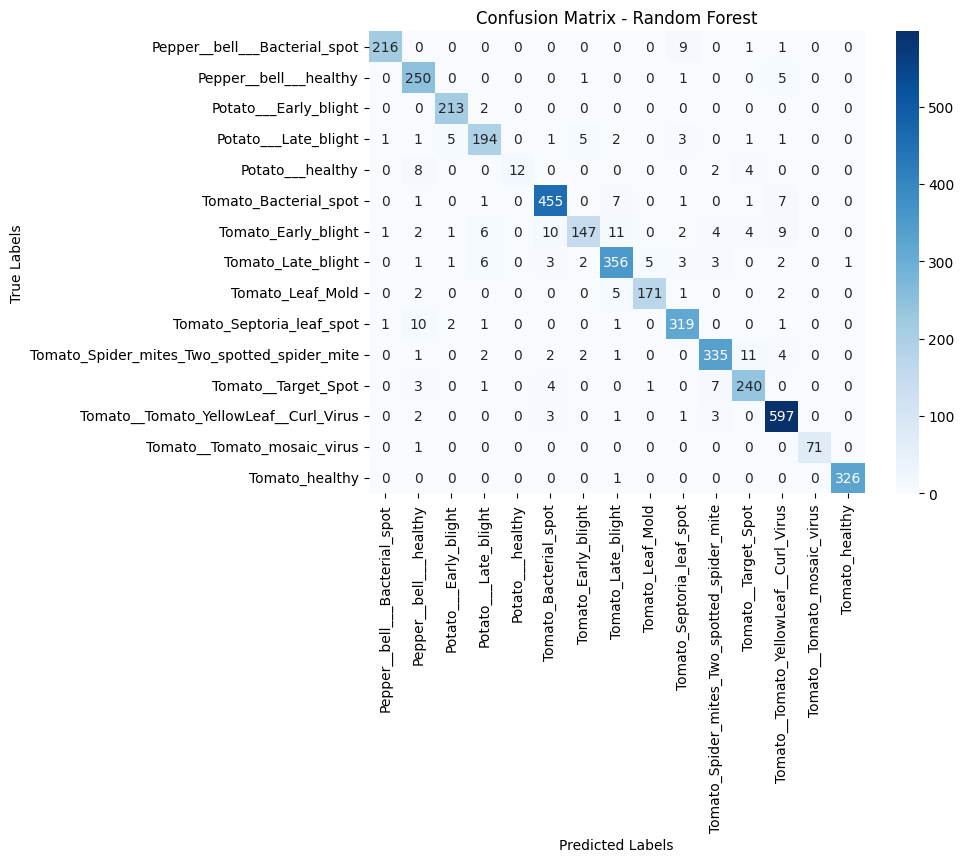

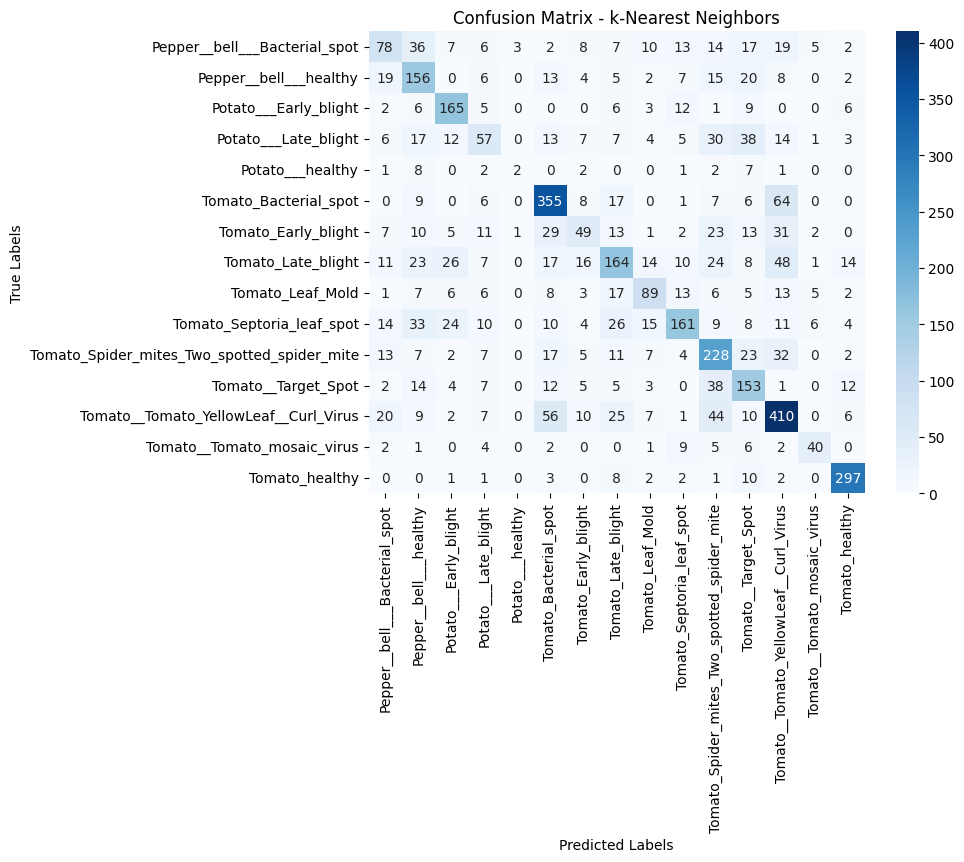

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


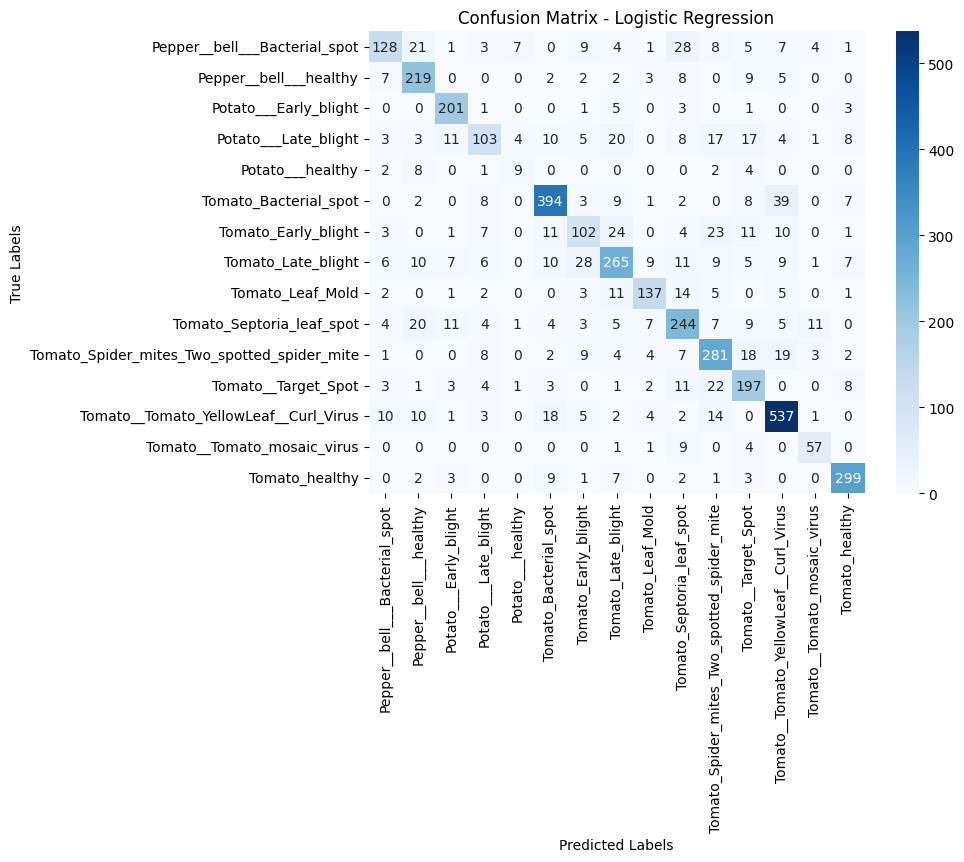

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


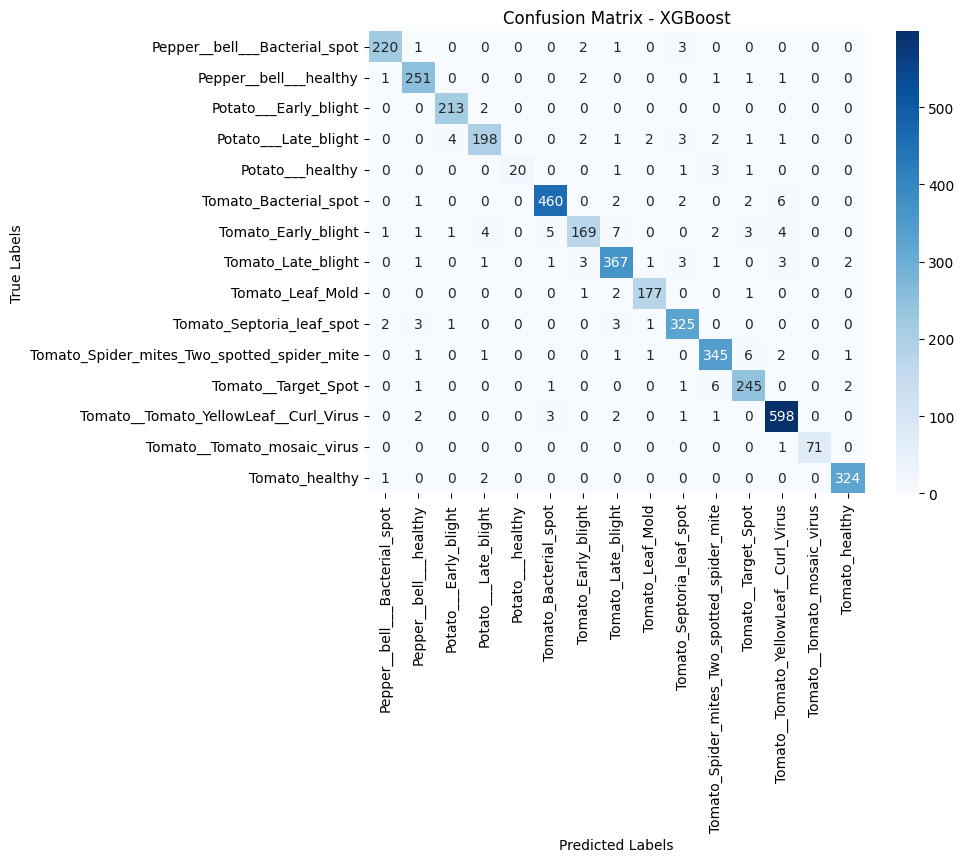

In [19]:
# Step 5: Generate confusion matrices for all models
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

In [21]:
    # Generate classification report

    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    print("-" * 80)

Classification Report for XGBoost:

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.98      0.97      0.97       227
                     Pepper__bell___healthy       0.96      0.98      0.97       257
                      Potato___Early_blight       0.97      0.99      0.98       215
                       Potato___Late_blight       0.95      0.93      0.94       214
                           Potato___healthy       1.00      0.77      0.87        26
                      Tomato_Bacterial_spot       0.98      0.97      0.98       473
                        Tomato_Early_blight       0.94      0.86      0.90       197
                         Tomato_Late_blight       0.95      0.96      0.95       383
                           Tomato_Leaf_Mold       0.97      0.98      0.98       181
                  Tomato_Septoria_leaf_spot       0.96      0.97      0.96       335
Tomato_Spider_mites_Two_spot

In [22]:
# Display the final results DataFrame for summary
print("\nFinal Model Performance Summary:")
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by="Mean Accuracy", ascending=False)
print(results_df)


Final Model Performance Summary:
                     Mean Accuracy   Std Dev
XGBoost                   0.966228  0.001494
Random Forest             0.944666  0.003712
Logistic Regression       0.782489  0.007458
k-Nearest Neighbors       0.580918  0.004306
SVM (RBF Kernel)          0.255984  0.007379


In [14]:
# Step 5: Analyze the best-performing model
best_model_name = results_df.index[0]
best_model = models[best_model_name]
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:24:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


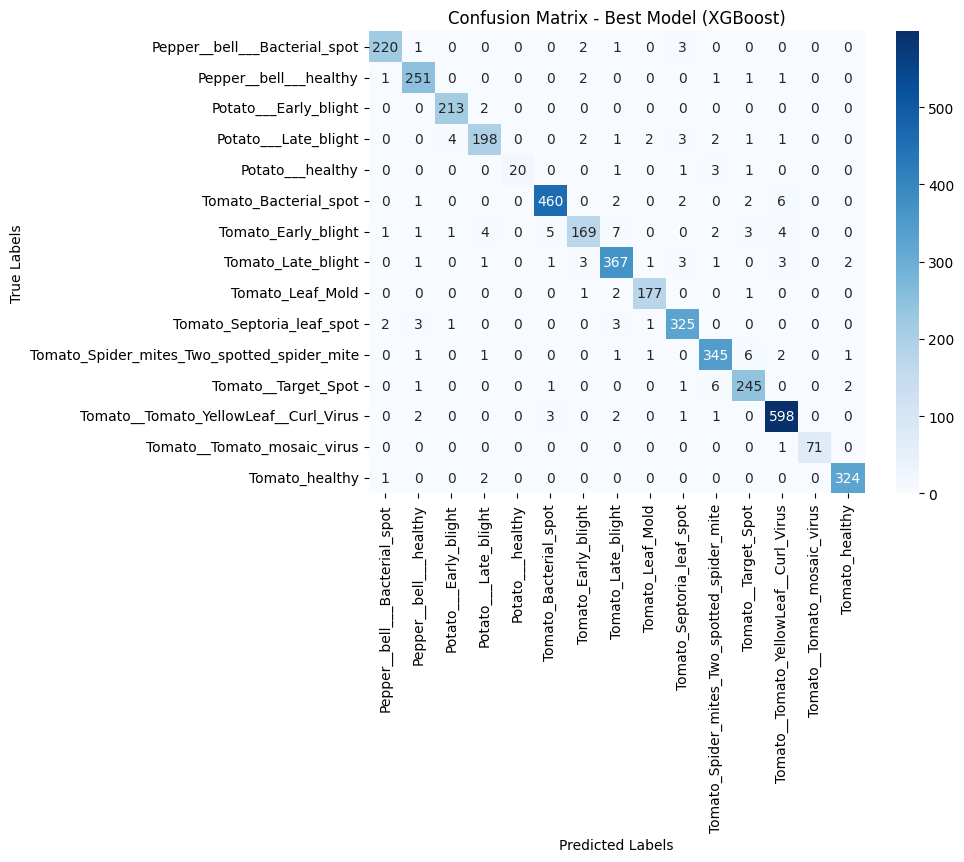

In [15]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix - Best Model ({best_model_name})')
plt.show()